In [ ]:
# https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-S2-deafrica.html#Import-Required-Packages

In [ ]:
from pystac_client import Client
from odc.stac import configure_rio, stac_load

In [2]:
config = {
    "s2_l2a": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "SCL": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
        },
        "aliases": {
            "costal_aerosol": "B01",
            "blue": "B02",
            "green": "B03",
            "red": "B04",
            "red_edge_1": "B05",
            "red_edge_2": "B06",
            "red_edge_3": "B07",
            "nir": "B08",
            "nir_narrow": "B08A",
            "water_vapour": "B09",
            "swir_1": "B11",
            "swir_2": "B12",
            "mask": "SCL",
            "aerosol_optical_thickness": "AOT",
            "scene_average_water_vapour": "WVP",
        },
    }
}

In [3]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

In [4]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

In [5]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [37.76, 12.49, 37.77, 12.50]

# Set a start and end date
start_date = "2020-09-01"
end_date = "2020-12-01"

# Set the STAC collections
collections = ["s2_l2a"]


# Build a query with the set parameters
query = catalog.search(
    bbox=bbox,
	collections=collections,
	datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 34 datasets


In [6]:
crs = "EPSG:6933"
resolution = 20

ds = stac_load(
    items,
    bands=("red", "green", "blue", "nir"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

In [12]:
type(ds)

xarray.core.dataset.Dataset

In [7]:
# View the Xarray Dataset
ds

<xarray.Dataset> Size: 421kB
Dimensions:      (y: 63, x: 49, time: 17)
Coordinates:
  * y            (y) float64 504B 1.582e+06 1.582e+06 ... 1.581e+06 1.581e+06
  * x            (x) float64 392B 3.643e+06 3.643e+06 ... 3.644e+06 3.644e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 136B 2020-09-03T08:06:43 ... 2020-11-2...
Data variables:
    red          (time, y, x) uint16 105kB dask.array<chunksize=(1, 63, 49), meta=np.ndarray>
    green        (time, y, x) uint16 105kB dask.array<chunksize=(1, 63, 49), meta=np.ndarray>
    blue         (time, y, x) uint16 105kB dask.array<chunksize=(1, 63, 49), meta=np.ndarray>
    nir          (time, y, x) uint16 105kB dask.array<chunksize=(1, 63, 49), meta=np.ndarray>

In [8]:
ds["NDVI"] = (ds.nir - ds.red) / (ds.nir + ds.red)

In [11]:
ds

<xarray.Dataset> Size: 841kB
Dimensions:      (y: 63, x: 49, time: 17)
Coordinates:
  * y            (y) float64 504B 1.582e+06 1.582e+06 ... 1.581e+06 1.581e+06
  * x            (x) float64 392B 3.643e+06 3.643e+06 ... 3.644e+06 3.644e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 136B 2020-09-03T08:06:43 ... 2020-11-2...
Data variables:
    red          (time, y, x) uint16 105kB dask.array<chunksize=(1, 63, 49), meta=np.ndarray>
    green        (time, y, x) uint16 105kB dask.array<chunksize=(1, 63, 49), meta=np.ndarray>
    blue         (time, y, x) uint16 105kB dask.array<chunksize=(1, 63, 49), meta=np.ndarray>
    nir          (time, y, x) uint16 105kB dask.array<chunksize=(1, 63, 49), meta=np.ndarray>
    NDVI         (time, y, x) float64 420kB dask.array<chunksize=(1, 63, 49), meta=np.ndarray>

/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


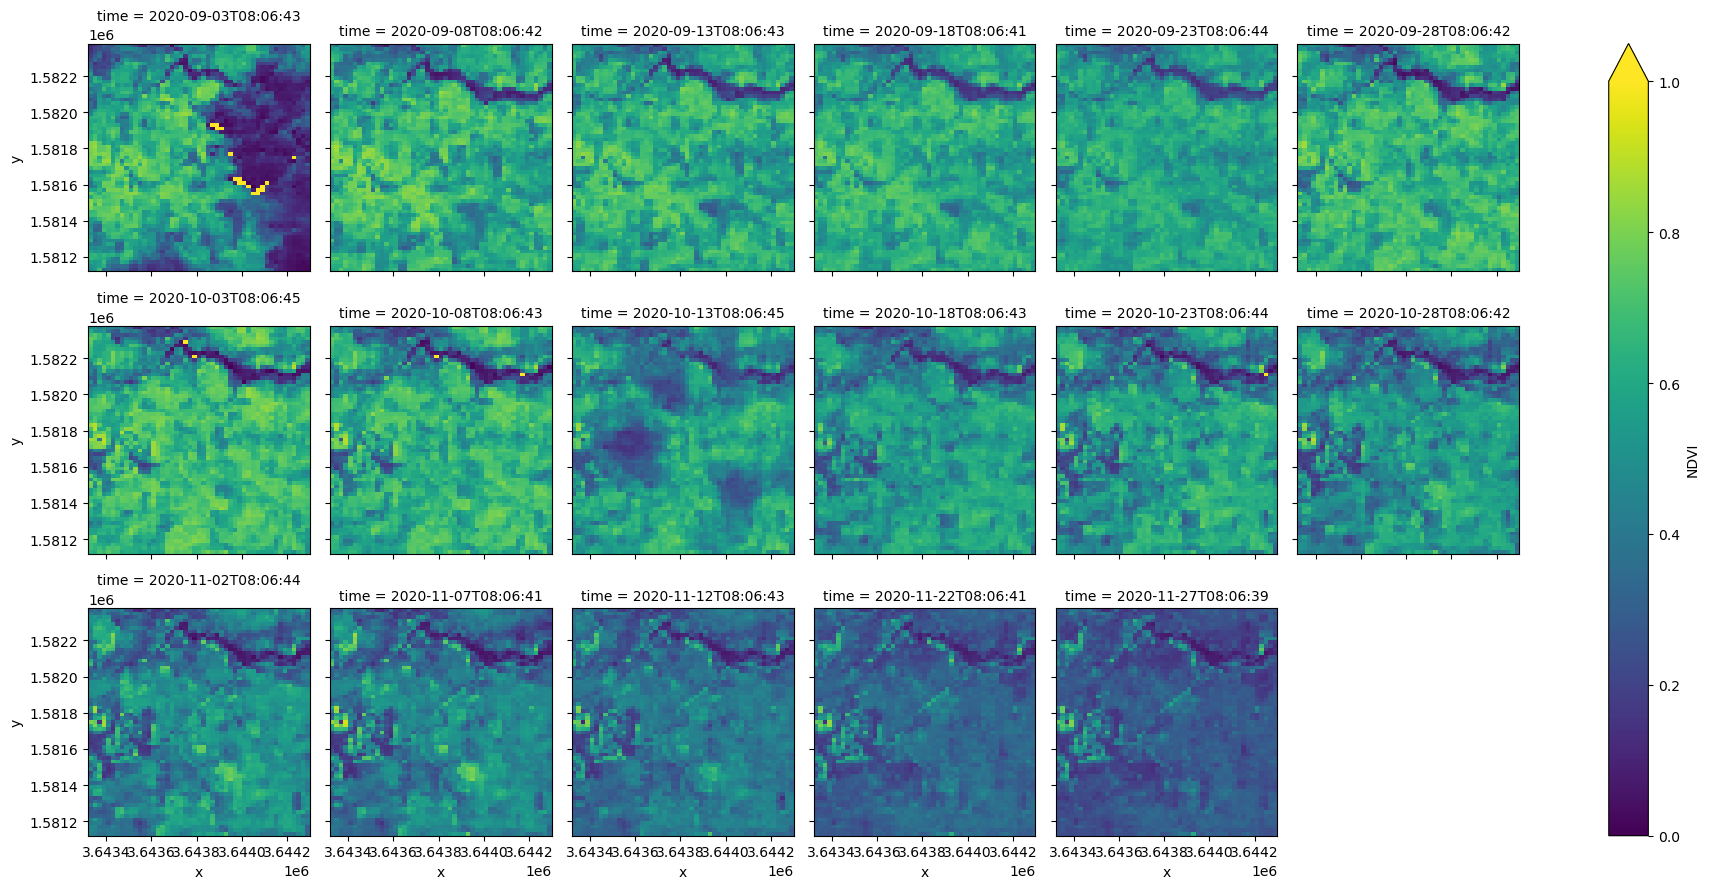

In [9]:
ds.NDVI.compute().plot(col="time", col_wrap=6, vmin=0, vmax=1)